# Stability of Sensor Selection at Various Time Horizons

This note book asks if the sensor selection protocol changes as the time horizon of the Grammian computation is extended.

In [2]:
# Imports
import pandas as pd
import numpy as np
from copy import deepcopy
import os
import sys
from importlib import reload
from scipy.stats import zscore
import scipy.io
#from scipy.interpolate import make_interp_spline, BSpline
#from scipy.signal import savgol_filter as savgol 
#from sklearn.decomposition import PCA
#from sklearn.neighbors import NearestNeighbors
#import leidenalg
#import umap
#import time
import gget
#from sklearn import preprocessing
#from sklearn.preprocessing import StandardScaler
#from scipy.signal import savgol_filter
import scipy
import textwrap
from scipy import sparse
import importlib

#from pydmd import DMD

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# local imports
sys.path.append("../python/")

import nb_util as nb
import utils as ut
reload(ut)

import hasnain_DMD
reload(hasnain_DMD)

import sensorSelection
reload(sensorSelection)

def getC(n, idxs):
    C = np.zeros((len(idxs), n))
    for i in range(len(idxs)):
        C[i, int(idxs[i])] = 1
    return C

def wrap_ylabels(ax, width):
    labels = []
    for label in ax.get_yticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=False))
    ax.set_yticklabels(labels, rotation=0)

/home/jpic/DMD_gene/notebooks/nb_util.py:113: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gf = pd.read_csv(gene_table_path)
/home/jpic/DMD_gene/notebooks/nb_util.py:113: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gf = pd.read_csv(gene_table_path)


(19235, 18)
(19235, 48)


In [ ]:
# 2015 data
data_path_2015 = f"/nfs/turbo/umms-indikar/shared/projects/cell_cycle/data/RNA_pipeline_ouputs/countMatrix/counts.raw.txt"
gene_path_2015 = f"/nfs/turbo/umms-indikar/shared/projects/cell_cycle/data/RNA_pipeline_ouputs/references/geneTable.csv"

# 2018 data
data_path_2018 = f"/nfs/turbo/umms-indikar/shared/projects/myod/data/rnaseq/2018_rna/countMatrix/counts.raw.txt"
gene_path_2018 = f"/nfs/turbo/umms-indikar/shared/projects/myod/data/rnaseq/2018_rna/references/geneTable.csv"

# Load the raw expression
df_2015 = pd.read_csv(data_path_2015, index_col=0)
df_2018 = pd.read_csv(data_path_2018, index_col=0)

# remove MT and ribosomal genes
all_genes_2015 = df_2015.index.to_list()
all_genes_2018 = df_2018.index.to_list()
mt_genes_2015 = [x for x in all_genes_2015 if x.startswith('MT-')]
rp_genes_2015 = [x for x in all_genes_2015 if x.startswith('RP')]
mt_genes_2018 = [x for x in all_genes_2018 if x.startswith('MT-')]
rp_genes_2018 = [x for x in all_genes_2018 if x.startswith('RP')]
df_2015 = df_2015.drop(mt_genes_2015) # drop MT genes
df_2015 = df_2015.drop(rp_genes_2015) # drop ribosomal genes
df_2018 = df_2018.drop(mt_genes_2018) # drop MT genes
df_2018 = df_2018.drop(rp_genes_2018) # drop ribosomal genes

# rewrite the list for removed genes
gene_names_2015 = df_2015.index.to_list()
gene_names_2018 = df_2018.index.to_list()

# Load gene lengths
gf_2015 = nb.getGeneLengths(gene_path_2015, gene_names_2015)
gf_2018 = nb.getGeneLengths(gene_path_2018, gene_names_2018)

# Convert to TPM
tpm_2015 = nb.TPM(df_2015, gf_2015)
tpm_2018 = nb.TPM(df_2018, gf_2018)

print(tpm_2015.shape)
print(tpm_2018.shape)

In [3]:
# filter out uninteresting genes
def filterGeneSet(tpm_2015, tpm_2018, k=1000, criteria='entropy'):
    if criteria == 'entropy':
        tpm_2015_normalized = tpm_2015.div(tpm_2015.sum(axis=1), axis=0)
        tpm_2018_normalized = tpm_2018.div(tpm_2018.sum(axis=1), axis=0)
        tpm_score_2015 = -(tpm_2015_normalized * np.log(tpm_2015_normalized)).sum(axis=1)
        tpm_score_2018 = -(tpm_2018_normalized * np.log(tpm_2018_normalized)).sum(axis=1)
    elif criteria == 'avg. expression':
        tpm_score_2015 = tpm_2015.mean(axis=1)
        tpm_score_2018 = tpm_2018.mean(axis=1)
    elif criteria == 'std.':
        tpm_score_2015 = tpm_2015.std(axis=1)
        tpm_score_2018 = tpm_2018.std(axis=1)

    # select k largest indices
    top_k_indices_2015 = tpm_score_2015.nlargest(k).index
    top_k_indices_2018 = tpm_score_2018.nlargest(k).index

    # take union of genes selected from 2015 and 2018
    include_indices = (top_k_indices_2015).union(top_k_indices_2018)

    # remove genes not aparent in both 2015 and 2018
    common_indices = set(tpm_2015.index) & set(tpm_2018.index)
    include_indices = include_indices.intersection(common_indices)

    # recude the data to have the same indices
    tpm_r_2015 = tpm_2015[tpm_2015.index.isin(include_indices)]
    tpm_r_2018 = tpm_2018[tpm_2015.index.isin(include_indices)]

    # convert to DMD format
    dmd_data_2015 = nb.data2DMD(tpm_r_2015)
    dmd_data_2018 = nb.data2DMD2017(tpm_r_2018)
    gene_list = include_indices
    return dmd_data_2015, dmd_data_2018, gene_list

selectionCriteria = ['entropy', 'avg. expression', 'std.']
dmd_data_2015, dmd_data_2018, gene_list = filterGeneSet(tpm_2015, tpm_2018, k=1000, criteria=selectionCriteria[0])

print(dmd_data_2015.shape)
print(dmd_data_2018.shape)

(1770, 8, 2)
(1770, 15, 2)


/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [6]:
# gram_horizons = [1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50,60,70,80,90]
# gram_horizons = [100,125,150,175,200,250,300,350,400,500]
# ss2015 = {'dmd': None}

for gramT in gram_horizons:
    print(gramT)
    ss2015 = sensorSelection.hasnain2023(dmd_data_2015, dmd_rank=7, gramT=gramT, vxNames=gene_list, dmd_res=ss2015['dmd'])   
    ss2015['sensors'].to_csv('~/DMD_gene/notebooks/gramStability/gramTsensors_' + str(gramT) + '.csv')

100
125
150
175
200
250
300
350
400
500


In [8]:
topKsensors = 50
geneSet = set()
gram_horizons = [1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50,60,70,80,90,100,125,150,175,200,250,300,350,400,500]
for gramT in gram_horizons:
    df = pd.read_csv('~/DMD_gene/notebooks/gramStability/gramTsensors_' + str(gramT) + '.csv')
    geneSet = geneSet.union(set(df['gene'].values[0:topKsensors]))
    print(str(gramT) + ': ' + str(len(geneSet)))

1: 50
2: 51
3: 101
4: 101
5: 101
6: 101
7: 102
8: 102
9: 103
10: 103
15: 103
20: 103
25: 103
30: 103
35: 103
40: 103
45: 103
50: 105
60: 105
70: 105
80: 105
90: 105
100: 105
125: 105
150: 105
175: 105
200: 105
250: 105
300: 105
350: 105
400: 106
500: 106


In [16]:
dfW = pd.DataFrame()
for gramT in gram_horizons:
    df = pd.read_csv('~/DMD_gene/notebooks/gramStability/gramTsensors_' + str(gramT) + '.csv')

    # Filter 'weight' entries for genes in gene_list
    filtered_weights = df[df['gene'].isin(geneSet)]['weight']
    print(filtered_weights.shape)
    print(dfW.shape)
    # Add a column to dfW for the current iteration
    dfW['Itr: ' + str(gramT)] = filtered_weights

# Print or use dfW as needed
print(dfW)

    
    #geneSet = geneSet.union(set(df['gene'].values[0:topKsensors]))
    #print(str(gramT) + ': ' + str(len(geneSet)))

(106,)
(0, 0)
(106,)
(106, 1)
(106,)
(106, 2)
(106,)
(106, 3)
(106,)
(106, 4)
(106,)
(106, 5)
(106,)
(106, 6)
(106,)
(106, 7)
(106,)
(106, 8)
(106,)
(106, 9)
(106,)
(106, 10)
(106,)
(106, 11)
(106,)
(106, 12)
(106,)
(106, 13)
(106,)
(106, 14)
(106,)
(106, 15)
(106,)
(106, 16)
(106,)
(106, 17)
(106,)
(106, 18)
(106,)
(106, 19)
(106,)
(106, 20)
(106,)
(106, 21)
(106,)
(106, 22)
(106,)
(106, 23)
(106,)
(106, 24)
(106,)
(106, 25)
(106,)
(106, 26)
(106,)
(106, 27)
(106,)
(106, 28)
(106,)
(106, 29)
(106,)
(106, 30)
(106,)
(106, 31)
        Itr: 1    Itr: 2    Itr: 3    Itr: 4    Itr: 5    Itr: 6    Itr: 7  \
0     0.009387  0.009202  0.514585  0.523831  0.009433  0.510020  0.513669   
1     0.009387  0.009202  0.287164  0.296582  0.009433  0.288894  0.290858   
2     0.009386  0.009202  0.232711  0.232742  0.009433  0.235083  0.234105   
3     0.009386  0.009202  0.215255  0.212397  0.009433  0.220732  0.221827   
4     0.009386  0.009202  0.205596  0.202446  0.009433  0.214177  0.215413   


In [17]:
W = dfW.values

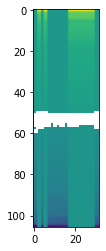

In [18]:
plt.imshow(W)

In [11]:
df

,Unnamed: 0,gene,ev1,weight,rank
0,0,TSPAN6,(0.009486746536774502+0j),0.009487,1.0
1,1,MMP2,(0.00948504399567086+0j),0.009485,2.0
2,2,GNAQ,(0.00948492399128753+0j),0.009485,3.0
3,3,CNRIP1,(0.009484833295824748+0j),0.009485,5.0
4,4,ANTXR1,(0.009484833295824748+0j),0.009485,5.0
...,...,...,...,...,...
1765,1765,EEF1B2,(-0.23506810050869542+0j),-0.235068,1766.0
1766,1766,HLA-B,(-0.2487687619073092+0j),-0.248769,1767.0
1767,1767,RACK1,(-0.2543571974870744+0j),-0.254357,1768.0
1768,1768,PTMA,(-0.2767886605763777+0j),-0.276789,1769.0
